In [38]:
import numpy as np
import gym
from gym import spaces
import matplotlib.pyplot as plt
import random

In [39]:
grid = np.zeros((5,5))
print(grid)

[[0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0.]]


In [40]:
pos1 = [0,0]
pos2 = [4,4]
pos3 = [1,1]
pos4 = [3,4]
pos5 = [4,0]
pos6 = [3,1]
pos7 = [0,4]

In [41]:
grid[tuple(pos1)] = 1
grid[tuple(pos2)] = 5
grid[tuple(pos3)] = 2
grid[tuple(pos4)] = 3
grid[tuple(pos5)] = 4
grid[tuple(pos6)] = 6
grid[tuple(pos7)] = 7

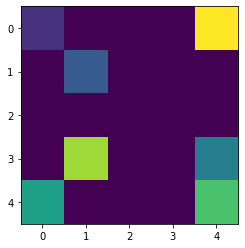

In [42]:
plt.imshow(grid)

In [43]:
class GridEnvironment(gym.Env):
    
    def __init__(self):
        self.observation_space = spaces.Discrete(25)
        self.action_space = spaces.Discrete(6)
        self.max_timesteps = 20
        
    def reset(self):
        self.timestep = 0
        self.agent_pos = [0, 0]
        self.goal_pos = [4, 4]
        self.pos3 = [1,1]
        self.pos4 = [3,4]
        self.pos5 = [4,0]
        self.state = np.zeros((5, 5))
        self.state[tuple(self.agent_pos)] = 1
        self.state[tuple(self.goal_pos)] = 5
        self.state[tuple(self.pos3)] = 2
        self.state[tuple(self.pos4)] = 3
        self.state[tuple(self.pos5)] = 4
        observation = self.state.flatten()
        
        return self.agent_pos
    
    def can_move_delete(self,action):
        if self.agent_pos[0] == 0 and action == 1:
            return False
        if self.agent_pos[0] == 3 and action == 0:
            return False 
        if self.agent_pos[1] == 0 and action == 3:
            return False
        if self.agent_pos[1] == 3 and action == 2:
            return False
        return True
    
        
    def can_move(self,action):
        if self.agent_pos[0] == 0 and action == 3:
            return False
        if self.agent_pos[0] == 4 and action == 0:
            return False 
        if self.agent_pos[1] == 0 and action == 1:
            return False
        if self.agent_pos[1] == 4 and action == 2:
            return False
        self.agent_pos = np.array(self.agent_pos)
        if (self.agent_pos == [0,0]).all() and action == 1:
            return False
        if (self.agent_pos == [0,4]).all() and action == 2:
            return False
        if (self.agent_pos == [4,0]).all() and action == 1:
            return False
        if (self.agent_pos == [4,4]).all() and action == 2:
            return False
        return True
    
    def step(self,action):
        self.state = np.random.choice(self.observation_space.n)
        
        #info = "No Action Performed."
        
        movable = self.can_move(action)
        if movable:
            if action == 0:
                self.agent_pos[0] += 1 #down
            if action == 1:
                self.agent_pos[0] -= 1 #up
            if action == 2:
                self.agent_pos[1] += 1 #right
            if action == 3:
                self.agent_pos[1] -= 1 #left
        info = self.agent_pos
        self.agent_pos = np.clip(self.agent_pos, 0, 4)
        self.goal_pos = [4,4]
        self.pos3 = [1,1]
        self.pos4 = [3,4]
        self.pos5 = [4,0]
        self.state = np.zeros((5, 5))
        self.state[tuple(self.agent_pos)] = 1
        self.state[tuple(self.goal_pos)] = 5
        self.state[tuple(self.pos3)] = 2
        self.state[tuple(self.pos4)] = 3
        self.state[tuple(self.pos5)] = 4
        observation = self.state.flatten()
        terminate = False
        
        reward = 0
        
        if not movable:
            reward = 0
            
        elif (self.agent_pos == self.goal_pos).all():
            reward = 10
            terminate = True
        
        elif (self.agent_pos == (1,1)).all():
            reward = 8
            
        elif (self.agent_pos == (3,4)).all():
            reward = -5
            self.reset()
        
        elif (self.agent_pos == (4,0)).all():
            reward = -3
            
        self.timestep += 1
        done = self.timestep >= self.max_timesteps
        
        return self.agent_pos, reward, done, info, terminate
    
    def render(self):
        plt.imshow(self.state)

# Deterministic Model

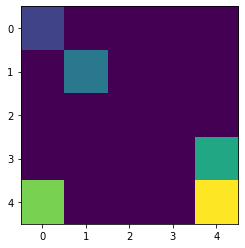

In [44]:
deterministic_env = GridEnvironment() #false -> deterministic
obs = deterministic_env.reset()
deterministic_env.render()

In [45]:
for _ in range(0,10):
    action = random.randint(0,3)
    agent_pos, reward, done, info, terminate = deterministic_env.step(action)
    #deterministic_env.render()
    #plt.show()
    print("Action performed is ",action," , current position is ",info," and reward is ",reward)

Action performed is  0  , current position is  [1 0]  and reward is  0
Action performed is  2  , current position is  [1 1]  and reward is  8
Action performed is  0  , current position is  [2 1]  and reward is  0
Action performed is  1  , current position is  [1 1]  and reward is  8
Action performed is  1  , current position is  [0 1]  and reward is  0
Action performed is  2  , current position is  [0 2]  and reward is  0
Action performed is  3  , current position is  [0 2]  and reward is  0
Action performed is  0  , current position is  [1 2]  and reward is  0
Action performed is  0  , current position is  [2 2]  and reward is  0
Action performed is  3  , current position is  [2 1]  and reward is  0


# Actor Critic Algorithm

In [78]:
import torch as T
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import numpy as np
import random
class ACNetwork(nn.Module):
    def __init__(self,lr,input_dims,fc1_dims,fc2_dims,n_actions):
        super(ACNetwork, self).__init__()
        self.fc1_dims = fc1_dims
        self.fc2_dims = fc2_dims
        self.n_actions = n_actions

        self.fc1 = nn.Linear(input_dims,self.fc1_dims)
        self.fc2 = nn.Linear(self.fc1_dims, self.fc2_dims)
        self.fc3 = nn.Linear(self.fc2_dims, self.n_actions)

        self.optimizer = optim.Adam(self.parameters(),lr=lr)
        self.loss = nn.MSELoss()
        self.device = T.device('cuda:0' if T.cuda.is_available() else 'cpu')
        self.to(self.device)

    def forward(self, state):
        state = T.Tensor(state).to(self.device)
        layer1 = F.relu(self.fc1(state))
        layer2 = F.relu(self.fc2(layer1))
        actions = self.fc3(layer2)
        return actions

In [79]:
class ACAgent:
    def __init__(self,env, alpha, beta, input_dims, gamma,fc1_dims, fc2_dims, n_actions):
        self.env = env
        self.observation_space = env.observation_space
        self.action_space = env.action_space
       
        self.alpha = alpha
        self.beta = beta

        self.gamma = gamma

        self.actor = ACNetwork(alpha, input_dims, fc1_dims,fc2_dims, n_actions=n_actions)
        self.critic = ACNetwork(beta, input_dims, fc1_dims,fc2_dims, n_actions=1)
        
        self.log_p = None

    def step(self,observation):
        probabilities = F.softmax(self.actor.forward(observation))
        action_p = T.distributions.Categorical(probabilities)
        action = action_p.sample()
        self.log_p = action_p.log_prob(action)
        return action.item()
    

    def learn(self, state, reward, next_state, done):
        self.actor.optimizer.zero_grad()
        self.critic.optimizer.zero_grad()
        new_critic_value = 0
        if not done:
            new_critic_value = self.critic.forward(next_state)
        critic_value = self.critic.forward(state)
        reward = T.tensor(reward, dtype=T.float).to(self.actor.device)

        delta = reward + self.gamma*new_critic_value - critic_value
        critic_loss = delta**2
        actor_loss = -self.log_p * delta
        (actor_loss + critic_loss).backward()

        self.actor.optimizer.step()
        self.critic.optimizer.step()

# Grid - World

Action :  0
Reward :  0
Current Reward :  0
Action :  1
Reward :  0
Current Reward :  0
Action :  2
Reward :  8
Current Reward :  8
Action :  0
Reward :  0
Current Reward :  8
Action :  0
Reward :  0
Current Reward :  8
Action :  2
Reward :  0
Current Reward :  8
Action :  2
Reward :  0
Current Reward :  8
Action :  2
Reward :  -5
Current Reward :  3
Action :  1
Reward :  0
Current Reward :  3
Action :  1
Reward :  0
Current Reward :  3
Action :  3
Reward :  0
Current Reward :  3
Action :  2
Reward :  0
Current Reward :  3
Action :  0
Reward :  8
Current Reward :  11
Action :  0
Reward :  0
Current Reward :  11
Action :  2
Reward :  0
Current Reward :  11
Action :  2
Reward :  0
Current Reward :  11
Action :  1
Reward :  0
Current Reward :  11
Action :  1
Reward :  0
Current Reward :  11
Action :  2
Reward :  0
Current Reward :  11
Action :  0
Reward :  0
Current Reward :  11
Action :  3
Reward :  0
Current Reward :  11
Action :  3
Reward :  0
Current Reward :  11
Action :  3
Reward : 

/var/folders/bw/ct_pt6j167xdyq81hd4jpdz40000gn/T/ipykernel_31543/1927055332.py:18: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  probabilities = F.softmax(self.actor.forward(observation))


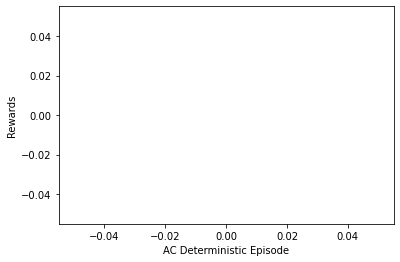

Action :  1
Reward :  0
Current Reward :  0
Action :  0
Reward :  0
Current Reward :  0
Action :  1
Reward :  0
Current Reward :  0
Action :  0
Reward :  0
Current Reward :  0
Action :  3
Reward :  0
Current Reward :  0
Action :  3
Reward :  0
Current Reward :  0
Action :  2
Reward :  0
Current Reward :  0
Action :  0
Reward :  0
Current Reward :  0
Action :  3
Reward :  0
Current Reward :  0
Action :  1
Reward :  0
Current Reward :  0
Action :  1
Reward :  0
Current Reward :  0
Action :  3
Reward :  0
Current Reward :  0
Action :  0
Reward :  -3
Current Reward :  -3
Action :  2
Reward :  0
Current Reward :  -3
Action :  0
Reward :  0
Current Reward :  -3
Action :  0
Reward :  0
Current Reward :  -3
Action :  2
Reward :  0
Current Reward :  -3
Action :  1
Reward :  0
Current Reward :  -3
Action :  3
Reward :  0
Current Reward :  -3
Action :  2
Reward :  0
Current Reward :  -3
Reward after 20 timesteps :  -3
Action :  1
Reward :  0
Current Reward :  0
Action :  0
Reward :  0
Current Rew

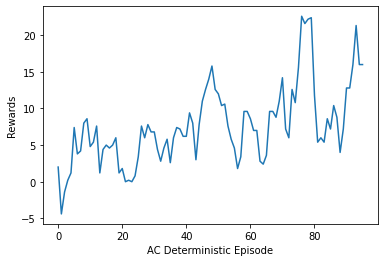

Action :  1
Reward :  0
Current Reward :  0
Action :  0
Reward :  0
Current Reward :  0
Action :  3
Reward :  0
Current Reward :  0
Action :  2
Reward :  8
Current Reward :  8
Action :  1
Reward :  0
Current Reward :  8
Action :  2
Reward :  0
Current Reward :  8
Action :  0
Reward :  0
Current Reward :  8
Action :  0
Reward :  0
Current Reward :  8
Action :  0
Reward :  0
Current Reward :  8
Action :  3
Reward :  0
Current Reward :  8
Action :  3
Reward :  0
Current Reward :  8
Action :  1
Reward :  0
Current Reward :  8
Action :  1
Reward :  0
Current Reward :  8
Action :  0
Reward :  -3
Current Reward :  5
Action :  2
Reward :  0
Current Reward :  5
Action :  1
Reward :  0
Current Reward :  5
Action :  2
Reward :  0
Current Reward :  5
Action :  0
Reward :  0
Current Reward :  5
Action :  2
Reward :  0
Current Reward :  5
Action :  3
Reward :  0
Current Reward :  5
Reward after 20 timesteps :  5
Action :  1
Reward :  0
Current Reward :  0
Action :  2
Reward :  0
Current Reward :  0


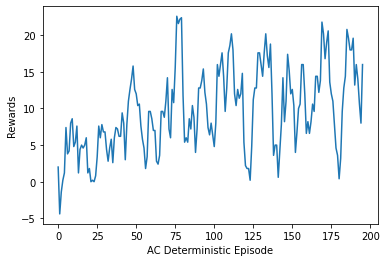

Action :  0
Reward :  0
Current Reward :  0
Action :  1
Reward :  0
Current Reward :  0
Action :  2
Reward :  8
Current Reward :  8
Action :  2
Reward :  0
Current Reward :  8
Action :  1
Reward :  0
Current Reward :  8
Action :  2
Reward :  0
Current Reward :  8
Action :  0
Reward :  0
Current Reward :  8
Action :  3
Reward :  0
Current Reward :  8
Action :  3
Reward :  8
Current Reward :  16
Action :  0
Reward :  0
Current Reward :  16
Action :  1
Reward :  8
Current Reward :  24
Action :  3
Reward :  0
Current Reward :  24
Action :  2
Reward :  8
Current Reward :  32
Action :  3
Reward :  0
Current Reward :  32
Action :  1
Reward :  0
Current Reward :  32
Action :  1
Reward :  0
Current Reward :  32
Action :  3
Reward :  0
Current Reward :  32
Action :  0
Reward :  0
Current Reward :  32
Action :  0
Reward :  0
Current Reward :  32
Action :  2
Reward :  0
Current Reward :  32
Reward after 20 timesteps :  32
Action :  1
Reward :  0
Current Reward :  0
Action :  3
Reward :  0
Current 

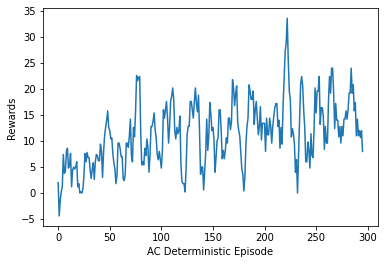

Action :  0
Reward :  0
Current Reward :  0
Action :  3
Reward :  0
Current Reward :  0
Action :  1
Reward :  0
Current Reward :  0
Action :  0
Reward :  0
Current Reward :  0
Action :  1
Reward :  0
Current Reward :  0
Action :  0
Reward :  0
Current Reward :  0
Action :  3
Reward :  0
Current Reward :  0
Action :  2
Reward :  0
Current Reward :  0
Action :  1
Reward :  0
Current Reward :  0
Action :  3
Reward :  0
Current Reward :  0
Action :  3
Reward :  0
Current Reward :  0
Action :  0
Reward :  0
Current Reward :  0
Action :  3
Reward :  0
Current Reward :  0
Action :  3
Reward :  0
Current Reward :  0
Action :  3
Reward :  0
Current Reward :  0
Action :  0
Reward :  -3
Current Reward :  -3
Action :  2
Reward :  0
Current Reward :  -3
Action :  2
Reward :  0
Current Reward :  -3
Action :  3
Reward :  0
Current Reward :  -3
Action :  2
Reward :  0
Current Reward :  -3
Reward after 20 timesteps :  -3
Action :  3
Reward :  0
Current Reward :  0
Action :  0
Reward :  0
Current Reward

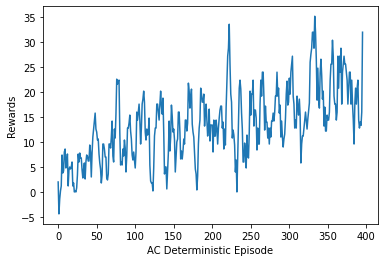

Action :  3
Reward :  0
Current Reward :  0
Action :  3
Reward :  0
Current Reward :  0
Action :  2
Reward :  0
Current Reward :  0
Action :  1
Reward :  0
Current Reward :  0
Action :  3
Reward :  0
Current Reward :  0
Action :  2
Reward :  0
Current Reward :  0
Action :  1
Reward :  0
Current Reward :  0
Action :  0
Reward :  0
Current Reward :  0
Action :  3
Reward :  8
Current Reward :  8
Action :  3
Reward :  0
Current Reward :  8
Action :  2
Reward :  8
Current Reward :  16
Action :  3
Reward :  0
Current Reward :  16
Action :  0
Reward :  0
Current Reward :  16
Action :  2
Reward :  0
Current Reward :  16
Action :  1
Reward :  8
Current Reward :  24
Action :  3
Reward :  0
Current Reward :  24
Action :  1
Reward :  0
Current Reward :  24
Action :  2
Reward :  8
Current Reward :  32
Action :  1
Reward :  0
Current Reward :  32
Action :  3
Reward :  0
Current Reward :  32
Reward after 20 timesteps :  32
Action :  2
Reward :  0
Current Reward :  0
Action :  2
Reward :  0
Current Re

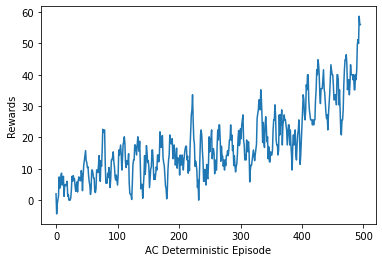

Action :  0
Reward :  0
Current Reward :  0
Action :  2
Reward :  8
Current Reward :  8
Action :  0
Reward :  0
Current Reward :  8
Action :  2
Reward :  0
Current Reward :  8
Action :  3
Reward :  0
Current Reward :  8
Action :  2
Reward :  0
Current Reward :  8
Action :  3
Reward :  0
Current Reward :  8
Action :  1
Reward :  8
Current Reward :  16
Action :  2
Reward :  0
Current Reward :  16
Action :  3
Reward :  8
Current Reward :  24
Action :  2
Reward :  0
Current Reward :  24
Action :  3
Reward :  8
Current Reward :  32
Action :  3
Reward :  0
Current Reward :  32
Action :  2
Reward :  8
Current Reward :  40
Action :  3
Reward :  0
Current Reward :  40
Action :  1
Reward :  0
Current Reward :  40
Action :  0
Reward :  0
Current Reward :  40
Action :  2
Reward :  0
Current Reward :  40
Action :  3
Reward :  0
Current Reward :  40
Action :  1
Reward :  0
Current Reward :  40
Reward after 20 timesteps :  40
Action :  0
Reward :  0
Current Reward :  0
Action :  2
Reward :  8
Current

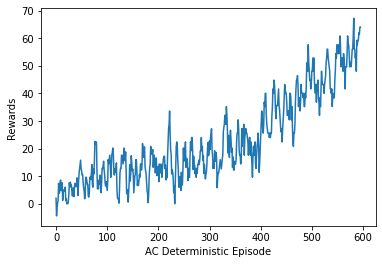

Action :  2
Reward :  0
Current Reward :  0
Action :  0
Reward :  8
Current Reward :  8
Action :  3
Reward :  0
Current Reward :  8
Action :  0
Reward :  0
Current Reward :  8
Action :  2
Reward :  0
Current Reward :  8
Action :  3
Reward :  0
Current Reward :  8
Action :  2
Reward :  0
Current Reward :  8
Action :  1
Reward :  8
Current Reward :  16
Action :  1
Reward :  0
Current Reward :  16
Action :  1
Reward :  0
Current Reward :  16
Action :  0
Reward :  8
Current Reward :  24
Action :  0
Reward :  0
Current Reward :  24
Action :  1
Reward :  8
Current Reward :  32
Action :  1
Reward :  0
Current Reward :  32
Action :  0
Reward :  8
Current Reward :  40
Action :  1
Reward :  0
Current Reward :  40
Action :  0
Reward :  8
Current Reward :  48
Action :  3
Reward :  0
Current Reward :  48
Action :  2
Reward :  8
Current Reward :  56
Action :  2
Reward :  0
Current Reward :  56
Reward after 20 timesteps :  56
Action :  3
Reward :  0
Current Reward :  0
Action :  2
Reward :  0
Current

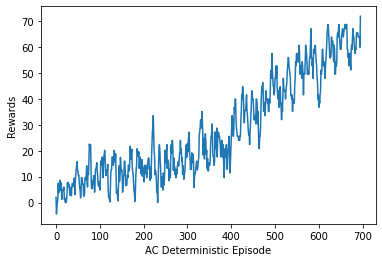

Action :  0
Reward :  0
Current Reward :  0
Action :  1
Reward :  0
Current Reward :  0
Action :  2
Reward :  8
Current Reward :  8
Action :  1
Reward :  0
Current Reward :  8
Action :  0
Reward :  8
Current Reward :  16
Action :  0
Reward :  0
Current Reward :  16
Action :  1
Reward :  8
Current Reward :  24
Action :  3
Reward :  0
Current Reward :  24
Action :  2
Reward :  8
Current Reward :  32
Action :  1
Reward :  0
Current Reward :  32
Action :  0
Reward :  8
Current Reward :  40
Action :  1
Reward :  0
Current Reward :  40
Action :  0
Reward :  8
Current Reward :  48
Action :  1
Reward :  0
Current Reward :  48
Action :  0
Reward :  8
Current Reward :  56
Action :  0
Reward :  0
Current Reward :  56
Action :  1
Reward :  8
Current Reward :  64
Action :  1
Reward :  0
Current Reward :  64
Action :  0
Reward :  8
Current Reward :  72
Action :  3
Reward :  0
Current Reward :  72
Reward after 20 timesteps :  72
Action :  1
Reward :  0
Current Reward :  0
Action :  2
Reward :  0
Curr

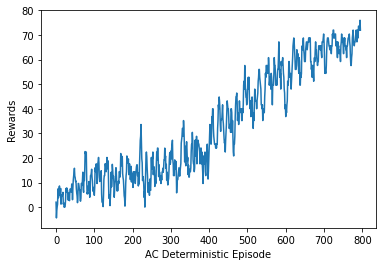

Action :  0
Reward :  0
Current Reward :  0
Action :  1
Reward :  0
Current Reward :  0
Action :  2
Reward :  8
Current Reward :  8
Action :  3
Reward :  0
Current Reward :  8
Action :  2
Reward :  8
Current Reward :  16
Action :  0
Reward :  0
Current Reward :  16
Action :  1
Reward :  8
Current Reward :  24
Action :  2
Reward :  0
Current Reward :  24
Action :  3
Reward :  8
Current Reward :  32
Action :  3
Reward :  0
Current Reward :  32
Action :  2
Reward :  8
Current Reward :  40
Action :  3
Reward :  0
Current Reward :  40
Action :  2
Reward :  8
Current Reward :  48
Action :  0
Reward :  0
Current Reward :  48
Action :  1
Reward :  8
Current Reward :  56
Action :  1
Reward :  0
Current Reward :  56
Action :  0
Reward :  8
Current Reward :  64
Action :  1
Reward :  0
Current Reward :  64
Action :  0
Reward :  8
Current Reward :  72
Action :  3
Reward :  0
Current Reward :  72
Reward after 20 timesteps :  72
Action :  2
Reward :  0
Current Reward :  0
Action :  0
Reward :  8
Curr

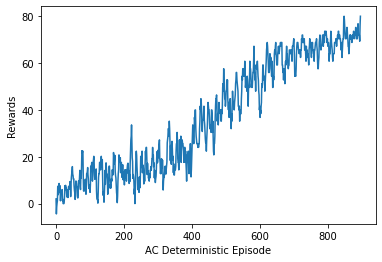

Action :  0
Reward :  0
Current Reward :  0
Action :  2
Reward :  8
Current Reward :  8
Action :  3
Reward :  0
Current Reward :  8
Action :  2
Reward :  8
Current Reward :  16
Action :  3
Reward :  0
Current Reward :  16
Action :  2
Reward :  8
Current Reward :  24
Action :  3
Reward :  0
Current Reward :  24
Action :  2
Reward :  8
Current Reward :  32
Action :  2
Reward :  0
Current Reward :  32
Action :  3
Reward :  8
Current Reward :  40
Action :  3
Reward :  0
Current Reward :  40
Action :  2
Reward :  8
Current Reward :  48
Action :  1
Reward :  0
Current Reward :  48
Action :  0
Reward :  8
Current Reward :  56
Action :  3
Reward :  0
Current Reward :  56
Action :  2
Reward :  8
Current Reward :  64
Action :  3
Reward :  0
Current Reward :  64
Action :  2
Reward :  8
Current Reward :  72
Action :  3
Reward :  0
Current Reward :  72
Action :  2
Reward :  8
Current Reward :  80
Reward after 20 timesteps :  80
Action :  2
Reward :  0
Current Reward :  0
Action :  0
Reward :  8
Cur

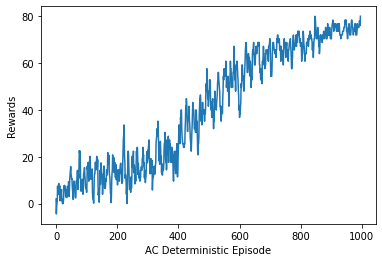

Action :  2
Reward :  0
Current Reward :  0
Action :  0
Reward :  8
Current Reward :  8
Action :  1
Reward :  0
Current Reward :  8
Action :  0
Reward :  8
Current Reward :  16
Action :  1
Reward :  0
Current Reward :  16
Action :  0
Reward :  8
Current Reward :  24
Action :  0
Reward :  0
Current Reward :  24
Action :  1
Reward :  8
Current Reward :  32
Action :  0
Reward :  0
Current Reward :  32
Action :  1
Reward :  8
Current Reward :  40
Action :  1
Reward :  0
Current Reward :  40
Action :  0
Reward :  8
Current Reward :  48
Action :  1
Reward :  0
Current Reward :  48
Action :  0
Reward :  8
Current Reward :  56
Action :  1
Reward :  0
Current Reward :  56
Action :  0
Reward :  8
Current Reward :  64
Action :  1
Reward :  0
Current Reward :  64
Action :  0
Reward :  8
Current Reward :  72
Action :  3
Reward :  0
Current Reward :  72
Action :  2
Reward :  8
Current Reward :  80
Reward after 20 timesteps :  80
Action :  0
Reward :  0
Current Reward :  0
Action :  2
Reward :  8
Cur

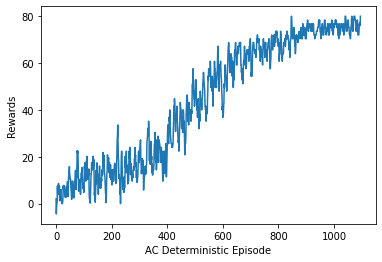

Action :  0
Reward :  0
Current Reward :  0
Action :  2
Reward :  8
Current Reward :  8
Action :  3
Reward :  0
Current Reward :  8
Action :  2
Reward :  8
Current Reward :  16
Action :  1
Reward :  0
Current Reward :  16
Action :  0
Reward :  8
Current Reward :  24
Action :  1
Reward :  0
Current Reward :  24
Action :  0
Reward :  8
Current Reward :  32
Action :  3
Reward :  0
Current Reward :  32
Action :  2
Reward :  8
Current Reward :  40
Action :  0
Reward :  0
Current Reward :  40
Action :  1
Reward :  8
Current Reward :  48
Action :  3
Reward :  0
Current Reward :  48
Action :  2
Reward :  8
Current Reward :  56
Action :  3
Reward :  0
Current Reward :  56
Action :  2
Reward :  8
Current Reward :  64
Action :  3
Reward :  0
Current Reward :  64
Action :  2
Reward :  8
Current Reward :  72
Action :  3
Reward :  0
Current Reward :  72
Action :  2
Reward :  8
Current Reward :  80
Reward after 20 timesteps :  80
Action :  0
Reward :  0
Current Reward :  0
Action :  2
Reward :  8
Cur

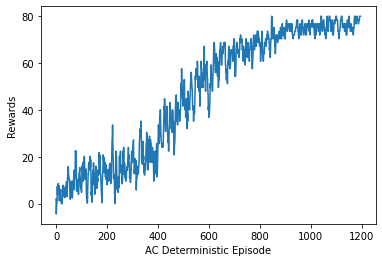

Action :  2
Reward :  0
Current Reward :  0
Action :  0
Reward :  8
Current Reward :  8
Action :  1
Reward :  0
Current Reward :  8
Action :  0
Reward :  8
Current Reward :  16
Action :  3
Reward :  0
Current Reward :  16
Action :  2
Reward :  8
Current Reward :  24
Action :  3
Reward :  0
Current Reward :  24
Action :  2
Reward :  8
Current Reward :  32
Action :  1
Reward :  0
Current Reward :  32
Action :  0
Reward :  8
Current Reward :  40
Action :  1
Reward :  0
Current Reward :  40
Action :  0
Reward :  8
Current Reward :  48
Action :  1
Reward :  0
Current Reward :  48
Action :  0
Reward :  8
Current Reward :  56
Action :  1
Reward :  0
Current Reward :  56
Action :  0
Reward :  8
Current Reward :  64
Action :  1
Reward :  0
Current Reward :  64
Action :  0
Reward :  8
Current Reward :  72
Action :  3
Reward :  0
Current Reward :  72
Action :  2
Reward :  8
Current Reward :  80
Reward after 20 timesteps :  80
Action :  2
Reward :  0
Current Reward :  0
Action :  0
Reward :  8
Cur

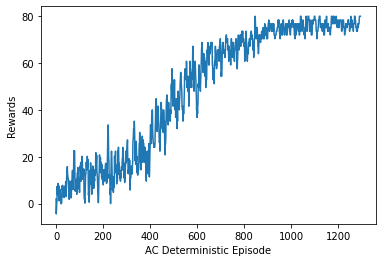

Action :  2
Reward :  0
Current Reward :  0
Action :  0
Reward :  8
Current Reward :  8
Action :  3
Reward :  0
Current Reward :  8
Action :  2
Reward :  8
Current Reward :  16
Action :  3
Reward :  0
Current Reward :  16
Action :  2
Reward :  8
Current Reward :  24
Action :  1
Reward :  0
Current Reward :  24
Action :  0
Reward :  8
Current Reward :  32
Action :  3
Reward :  0
Current Reward :  32
Action :  2
Reward :  8
Current Reward :  40
Action :  3
Reward :  0
Current Reward :  40
Action :  2
Reward :  8
Current Reward :  48
Action :  3
Reward :  0
Current Reward :  48
Action :  2
Reward :  8
Current Reward :  56
Action :  3
Reward :  0
Current Reward :  56
Action :  2
Reward :  8
Current Reward :  64
Action :  0
Reward :  0
Current Reward :  64
Action :  1
Reward :  8
Current Reward :  72
Action :  1
Reward :  0
Current Reward :  72
Action :  0
Reward :  8
Current Reward :  80
Reward after 20 timesteps :  80
Action :  2
Reward :  0
Current Reward :  0
Action :  0
Reward :  8
Cur

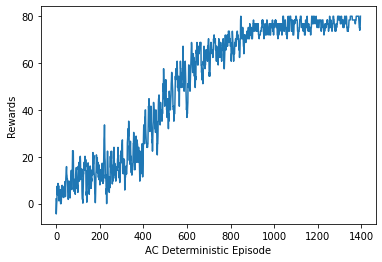

Action :  0
Reward :  0
Current Reward :  0
Action :  2
Reward :  8
Current Reward :  8
Action :  1
Reward :  0
Current Reward :  8
Action :  0
Reward :  8
Current Reward :  16
Action :  3
Reward :  0
Current Reward :  16
Action :  2
Reward :  8
Current Reward :  24
Action :  2
Reward :  0
Current Reward :  24
Action :  3
Reward :  8
Current Reward :  32
Action :  1
Reward :  0
Current Reward :  32
Action :  0
Reward :  8
Current Reward :  40
Action :  1
Reward :  0
Current Reward :  40
Action :  0
Reward :  8
Current Reward :  48
Action :  1
Reward :  0
Current Reward :  48
Action :  0
Reward :  8
Current Reward :  56
Action :  3
Reward :  0
Current Reward :  56
Action :  2
Reward :  8
Current Reward :  64
Action :  2
Reward :  0
Current Reward :  64
Action :  0
Reward :  0
Current Reward :  64
Action :  1
Reward :  0
Current Reward :  64
Action :  0
Reward :  0
Current Reward :  64
Reward after 20 timesteps :  64
Action :  2
Reward :  0
Current Reward :  0
Action :  0
Reward :  8
Cur

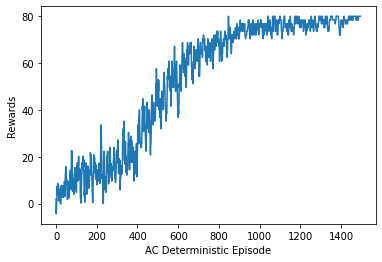

Action :  2
Reward :  0
Current Reward :  0
Action :  0
Reward :  8
Current Reward :  8
Action :  1
Reward :  0
Current Reward :  8
Action :  0
Reward :  8
Current Reward :  16
Action :  3
Reward :  0
Current Reward :  16
Action :  2
Reward :  8
Current Reward :  24
Action :  3
Reward :  0
Current Reward :  24
Action :  2
Reward :  8
Current Reward :  32
Action :  3
Reward :  0
Current Reward :  32
Action :  2
Reward :  8
Current Reward :  40
Action :  1
Reward :  0
Current Reward :  40
Action :  0
Reward :  8
Current Reward :  48
Action :  1
Reward :  0
Current Reward :  48
Action :  0
Reward :  8
Current Reward :  56
Action :  1
Reward :  0
Current Reward :  56
Action :  0
Reward :  8
Current Reward :  64
Action :  1
Reward :  0
Current Reward :  64
Action :  0
Reward :  8
Current Reward :  72
Action :  3
Reward :  0
Current Reward :  72
Action :  2
Reward :  8
Current Reward :  80
Reward after 20 timesteps :  80
Action :  2
Reward :  0
Current Reward :  0
Action :  0
Reward :  8
Cur

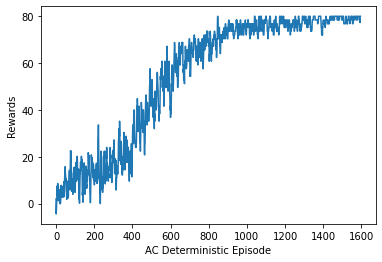

Action :  0
Reward :  0
Current Reward :  0
Action :  2
Reward :  8
Current Reward :  8
Action :  3
Reward :  0
Current Reward :  8
Action :  2
Reward :  8
Current Reward :  16
Action :  1
Reward :  0
Current Reward :  16
Action :  0
Reward :  8
Current Reward :  24
Action :  3
Reward :  0
Current Reward :  24
Action :  2
Reward :  8
Current Reward :  32
Action :  1
Reward :  0
Current Reward :  32
Action :  0
Reward :  8
Current Reward :  40
Action :  3
Reward :  0
Current Reward :  40
Action :  2
Reward :  8
Current Reward :  48
Action :  3
Reward :  0
Current Reward :  48
Action :  2
Reward :  8
Current Reward :  56
Action :  3
Reward :  0
Current Reward :  56
Action :  2
Reward :  8
Current Reward :  64
Action :  1
Reward :  0
Current Reward :  64
Action :  0
Reward :  8
Current Reward :  72
Action :  3
Reward :  0
Current Reward :  72
Action :  2
Reward :  8
Current Reward :  80
Reward after 20 timesteps :  80
Action :  0
Reward :  0
Current Reward :  0
Action :  2
Reward :  8
Cur

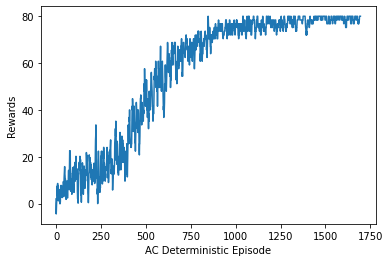

Action :  0
Reward :  0
Current Reward :  0
Action :  2
Reward :  8
Current Reward :  8
Action :  3
Reward :  0
Current Reward :  8
Action :  2
Reward :  8
Current Reward :  16
Action :  1
Reward :  0
Current Reward :  16
Action :  0
Reward :  8
Current Reward :  24
Action :  3
Reward :  0
Current Reward :  24
Action :  2
Reward :  8
Current Reward :  32
Action :  3
Reward :  0
Current Reward :  32
Action :  2
Reward :  8
Current Reward :  40
Action :  3
Reward :  0
Current Reward :  40
Action :  2
Reward :  8
Current Reward :  48
Action :  3
Reward :  0
Current Reward :  48
Action :  2
Reward :  8
Current Reward :  56
Action :  1
Reward :  0
Current Reward :  56
Action :  0
Reward :  8
Current Reward :  64
Action :  1
Reward :  0
Current Reward :  64
Action :  0
Reward :  8
Current Reward :  72
Action :  3
Reward :  0
Current Reward :  72
Action :  2
Reward :  8
Current Reward :  80
Reward after 20 timesteps :  80
Action :  0
Reward :  0
Current Reward :  0
Action :  2
Reward :  8
Cur

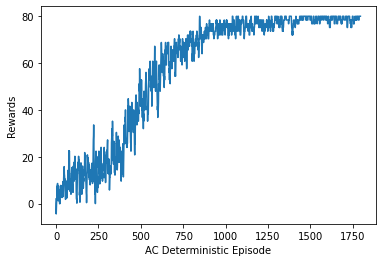

Action :  2
Reward :  0
Current Reward :  0
Action :  0
Reward :  8
Current Reward :  8
Action :  1
Reward :  0
Current Reward :  8
Action :  0
Reward :  8
Current Reward :  16
Action :  3
Reward :  0
Current Reward :  16
Action :  2
Reward :  8
Current Reward :  24
Action :  3
Reward :  0
Current Reward :  24
Action :  2
Reward :  8
Current Reward :  32
Action :  1
Reward :  0
Current Reward :  32
Action :  0
Reward :  8
Current Reward :  40
Action :  1
Reward :  0
Current Reward :  40
Action :  0
Reward :  8
Current Reward :  48
Action :  3
Reward :  0
Current Reward :  48
Action :  2
Reward :  8
Current Reward :  56
Action :  3
Reward :  0
Current Reward :  56
Action :  2
Reward :  8
Current Reward :  64
Action :  3
Reward :  0
Current Reward :  64
Action :  2
Reward :  8
Current Reward :  72
Action :  1
Reward :  0
Current Reward :  72
Action :  0
Reward :  8
Current Reward :  80
Reward after 20 timesteps :  80
Action :  2
Reward :  0
Current Reward :  0
Action :  0
Reward :  8
Cur

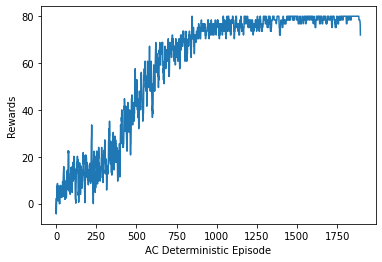

Action :  2
Reward :  0
Current Reward :  0
Action :  0
Reward :  8
Current Reward :  8
Action :  3
Reward :  0
Current Reward :  8
Action :  2
Reward :  8
Current Reward :  16
Action :  3
Reward :  0
Current Reward :  16
Action :  2
Reward :  8
Current Reward :  24
Action :  3
Reward :  0
Current Reward :  24
Action :  2
Reward :  8
Current Reward :  32
Action :  1
Reward :  0
Current Reward :  32
Action :  0
Reward :  8
Current Reward :  40
Action :  1
Reward :  0
Current Reward :  40
Action :  0
Reward :  8
Current Reward :  48
Action :  1
Reward :  0
Current Reward :  48
Action :  0
Reward :  8
Current Reward :  56
Action :  3
Reward :  0
Current Reward :  56
Action :  2
Reward :  8
Current Reward :  64
Action :  1
Reward :  0
Current Reward :  64
Action :  0
Reward :  8
Current Reward :  72
Action :  1
Reward :  0
Current Reward :  72
Action :  0
Reward :  8
Current Reward :  80
Reward after 20 timesteps :  80
Action :  2
Reward :  0
Current Reward :  0
Action :  0
Reward :  8
Cur

In [48]:
# setting up environment and agent
env = GridEnvironment()

agent = ACAgent(env=env,alpha=0.0001, beta=0.005, input_dims=2, gamma=0.9, fc1_dims=16, fc2_dims=32, n_actions=4)

episodes = 2000
q_d_rewards_1 = []

for episode in range(episodes):
    #print(episode)
    obs = env.reset()
    done = False
    curr_reward = 0

    while not done:
        action = agent.step(obs)
        #action = random.randint(0,3)
        state = np.copy(obs)
        obs, reward, done, info, terminate = env.step(action)
        #agent_pos, reward, done, info, terminate = deterministic_env.step(action)
        curr_reward+=reward
        next_state = np.copy(obs)
        print('Action : ',action)
        print('Reward : ',reward)
        curr_reward = round(curr_reward,2)
        print('Current Reward : ',curr_reward)

        agent.learn(state,reward,next_state,done)

    q_d_rewards_1.append(curr_reward)
    print('Reward after 20 timesteps : ',curr_reward)

    if not episode%100:
        window = 5
        plt.xlabel('AC Deterministic Episode')
        plt.ylabel('Rewards')
        plt.plot([np.mean(q_d_rewards_1[tr:tr+window]) for tr in range(window, len(q_d_rewards_1))])
        plt.show()


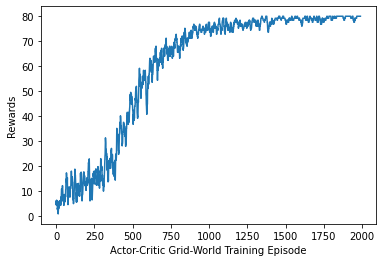

In [50]:
window = 10
plt.xlabel('Actor-Critic Grid-World Training Episode')
plt.ylabel('Rewards')
plt.plot([np.mean(q_d_rewards_1[tr:tr+window]) for tr in range(window, len(q_d_rewards_1))])

# Test Grid-World

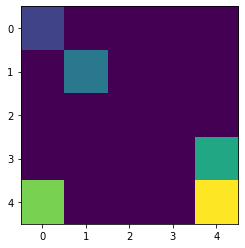

Episode  0
Action: 2
Reward: 0
Progressive Reward: 0
Action: 0
Reward: 8
Progressive Reward: 8
Action: 3
Reward: 0
Progressive Reward: 8
Action: 2
Reward: 8
Progressive Reward: 16
Action: 3
Reward: 0
Progressive Reward: 16
Action: 2
Reward: 8
Progressive Reward: 24
Action: 1
Reward: 0
Progressive Reward: 24
Action: 0
Reward: 8
Progressive Reward: 32
Action: 1
Reward: 0
Progressive Reward: 32
Action: 0
Reward: 8
Progressive Reward: 40
Action: 3
Reward: 0
Progressive Reward: 40
Action: 2
Reward: 8
Progressive Reward: 48
Action: 3
Reward: 0
Progressive Reward: 48
Action: 2
Reward: 8
Progressive Reward: 56
Action: 1
Reward: 0
Progressive Reward: 56
Action: 0
Reward: 8
Progressive Reward: 64
Action: 1
Reward: 0
Progressive Reward: 64
Action: 0
Reward: 8
Progressive Reward: 72
Action: 3
Reward: 0
Progressive Reward: 72
Action: 2
Reward: 8
Progressive Reward: 80
************************************************************
Episode  1
Action: 2
Reward: 0
Progressive Reward: 0
Action: 0
Reward: 

/var/folders/bw/ct_pt6j167xdyq81hd4jpdz40000gn/T/ipykernel_31543/1927055332.py:18: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  probabilities = F.softmax(self.actor.forward(observation))


Action: 1
Reward: 0
Progressive Reward: 16
Action: 0
Reward: 8
Progressive Reward: 24
Action: 1
Reward: 0
Progressive Reward: 24
Action: 0
Reward: 8
Progressive Reward: 32
Action: 2
Reward: 0
Progressive Reward: 32
Action: 3
Reward: 8
Progressive Reward: 40
Action: 1
Reward: 0
Progressive Reward: 40
Action: 0
Reward: 8
Progressive Reward: 48
Action: 1
Reward: 0
Progressive Reward: 48
Action: 0
Reward: 8
Progressive Reward: 56
Action: 3
Reward: 0
Progressive Reward: 56
Action: 2
Reward: 8
Progressive Reward: 64
Action: 3
Reward: 0
Progressive Reward: 64
Action: 2
Reward: 8
Progressive Reward: 72
Action: 3
Reward: 0
Progressive Reward: 72
Action: 2
Reward: 8
Progressive Reward: 80
************************************************************
Episode  7
Action: 0
Reward: 0
Progressive Reward: 0
Action: 2
Reward: 8
Progressive Reward: 8
Action: 3
Reward: 0
Progressive Reward: 8
Action: 2
Reward: 8
Progressive Reward: 16
Action: 3
Reward: 0
Progressive Reward: 16
Action: 2
Reward: 8
Progress

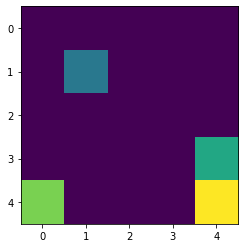

In [51]:
env = GridEnvironment()

obs = env.reset()
done = False
agent.epsilon = 0
env.render()
plt.show()
sum = 0
episode = 0
total_reward_epi = []

while episode <= 30:
    print('Episode ',episode)
    done = False
    terminate = False
    obs = env.reset()
    sum = 0
    while not done:
        action = agent.step(obs)
        obs, reward, done, info, terminate = env.step(action)
        env.render()
        #plt.show()
        print('Action:', action)
        print('Reward:', reward)
        sum += reward
        print('Progressive Reward:', sum)
        if terminate == True:
            break
    print('************************************************************')
    episode = episode + 1;
    total_reward_epi.append(sum)

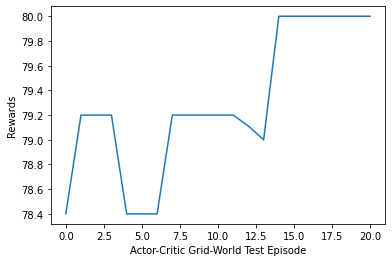

In [53]:
window = 10
plt.xlabel('Actor-Critic Grid-World Test Episode')
plt.ylabel('Rewards')
plt.plot([np.mean(total_reward_epi[tr:tr+window]) for tr in range(window, len(total_reward_epi))])

# CartPole-v1

/var/folders/bw/ct_pt6j167xdyq81hd4jpdz40000gn/T/ipykernel_31543/1927055332.py:18: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  probabilities = F.softmax(self.actor.forward(observation))


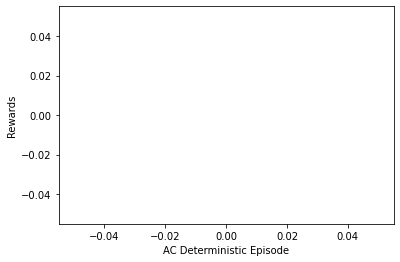

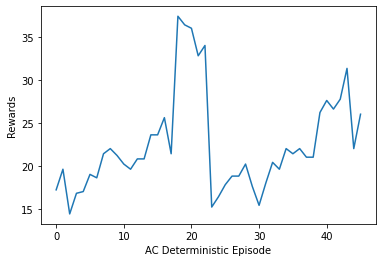

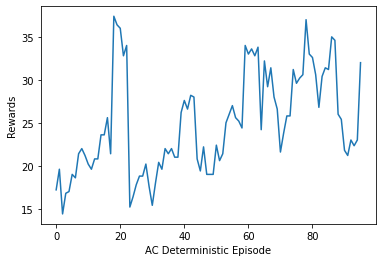

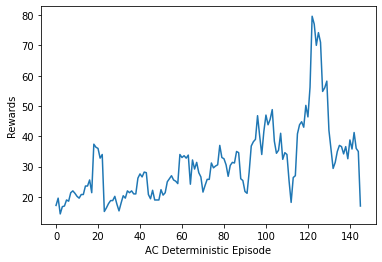

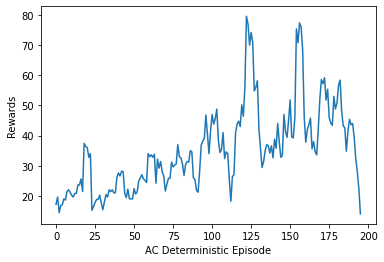

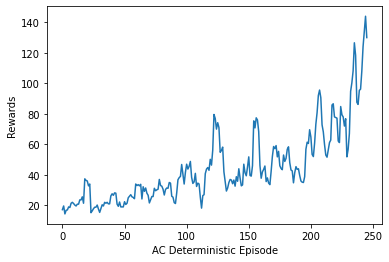

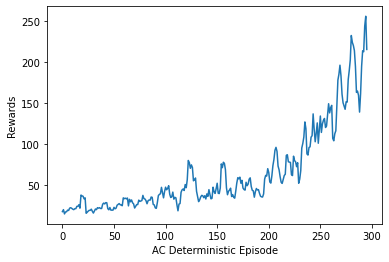

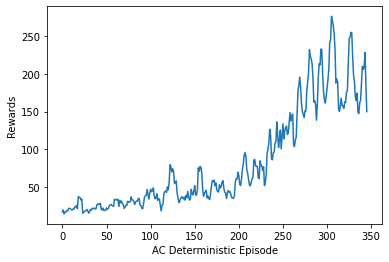

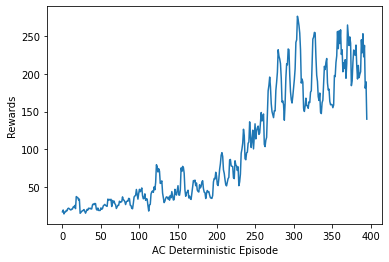

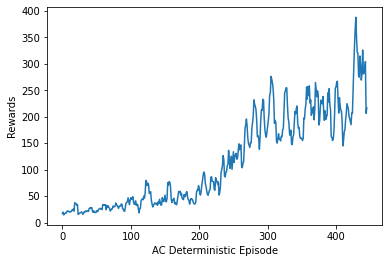

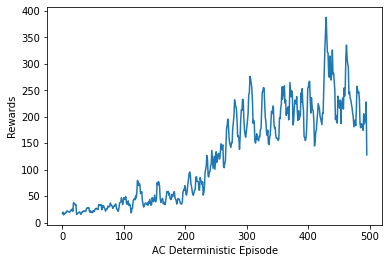

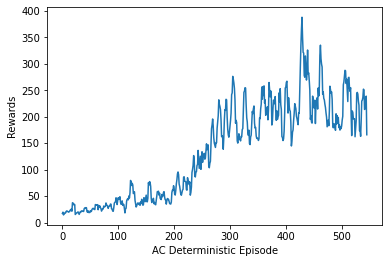

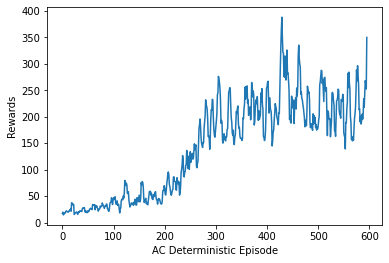

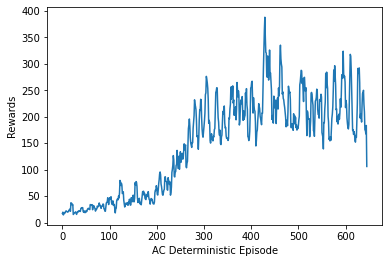

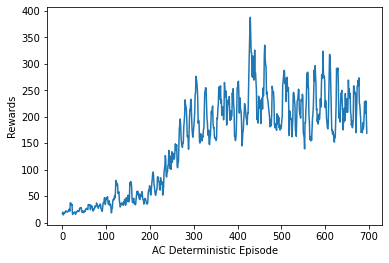

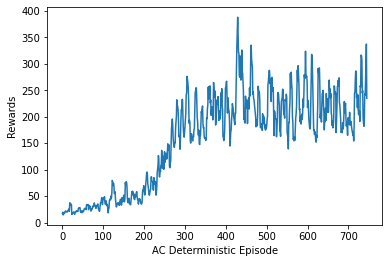

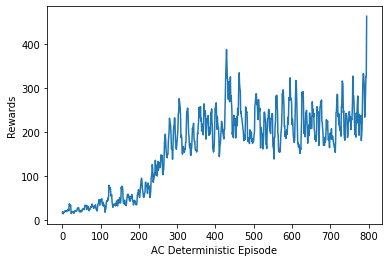

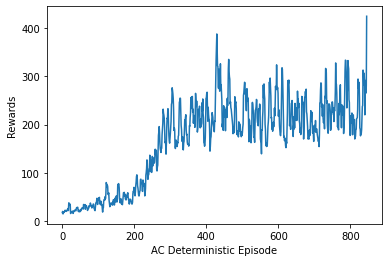

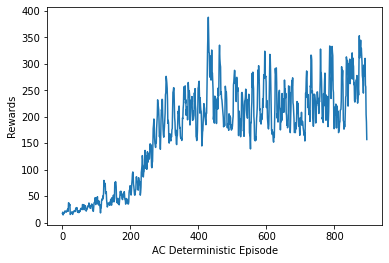

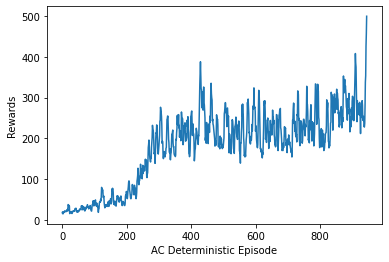

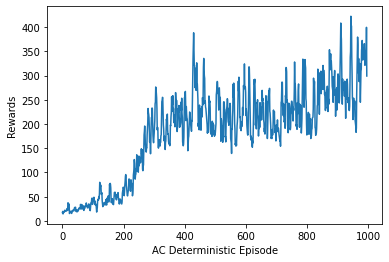

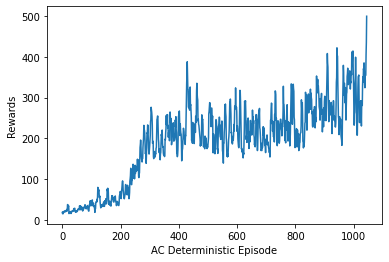

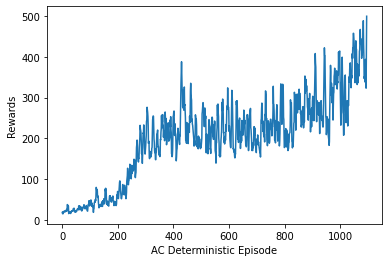

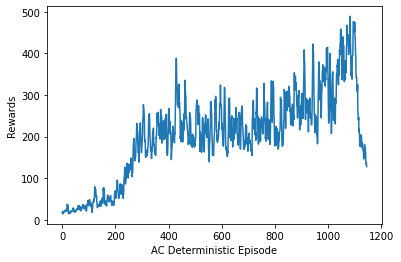

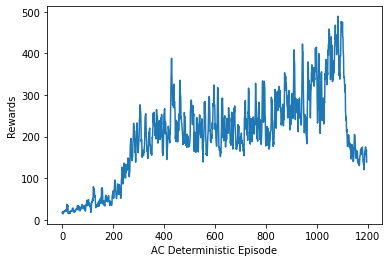

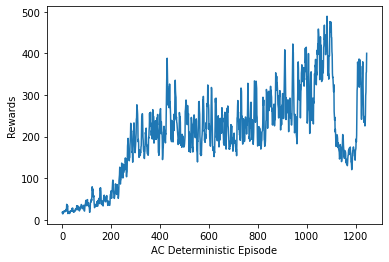

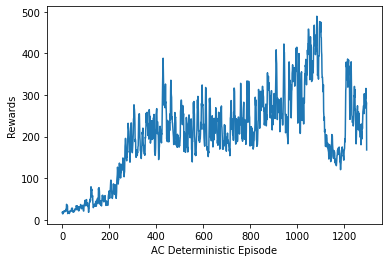

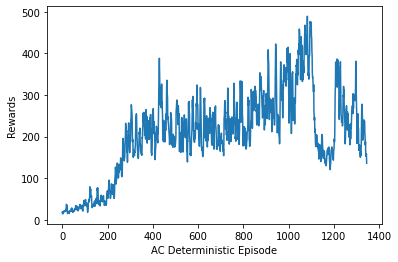

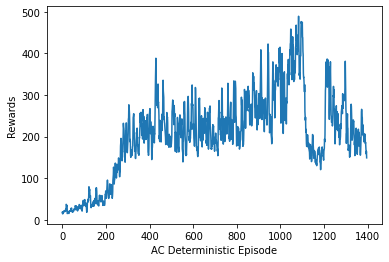

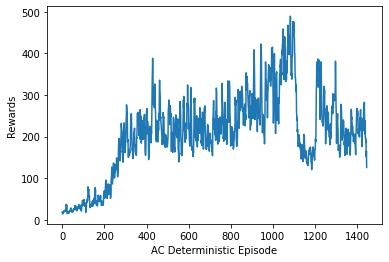

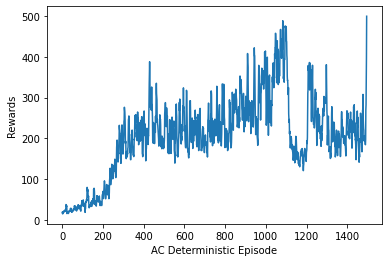

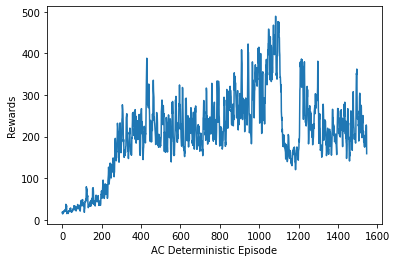

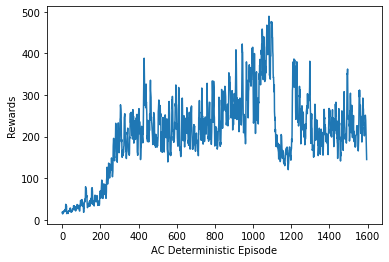

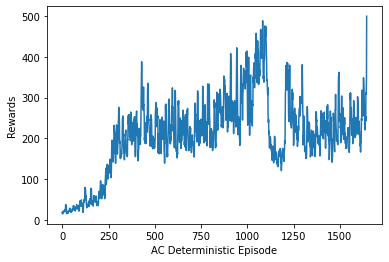

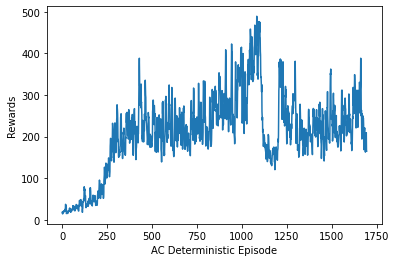

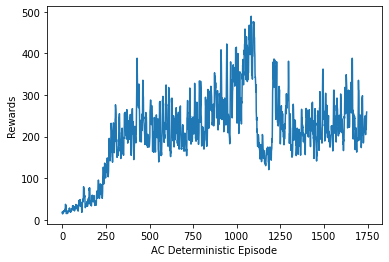

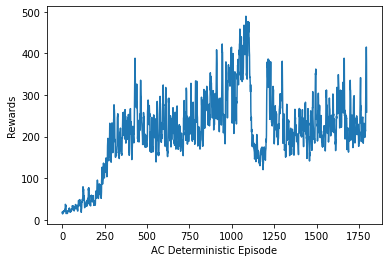

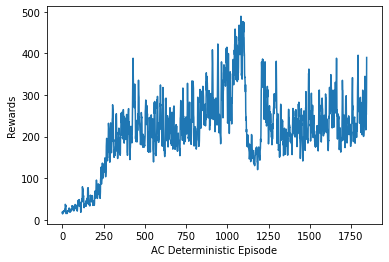

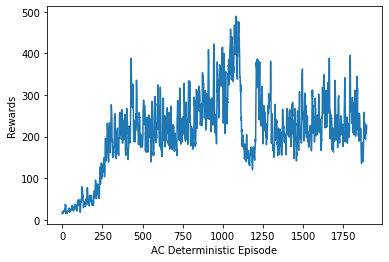

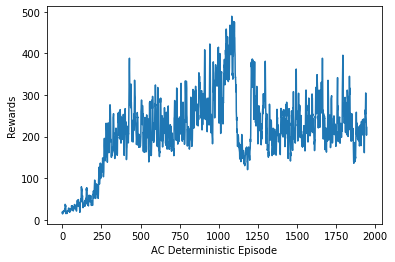

In [80]:
# setting up environment and agent
import gym
env = gym.make('CartPole-v1') 
env.reset()

agent = ACAgent(env=env, alpha=0.00001, beta=0.0005, input_dims=4, gamma=0.99, fc1_dims=256, fc2_dims=256, n_actions=2)
episodes = 2000

rewards_cartpole = []

for episode in range(episodes):
    #print(episode)
    obs = env.reset()
    done = False
    curr_reward = 0

    while not done:
        action = agent.step(obs)
        state = np.copy(obs)
        obs, reward, done, info = env.step(action)
        curr_reward+=reward
        next_state = np.copy(obs)
        agent.learn(state,reward,next_state,done)

    rewards_cartpole.append(curr_reward)

    if not episode%50:
        window = 5
        plt.xlabel('AC Deterministic Episode')
        plt.ylabel('Rewards')
        plt.plot([np.mean(rewards_cartpole[tr:tr+window]) for tr in range(window, len(rewards_cartpole))])
        plt.show()

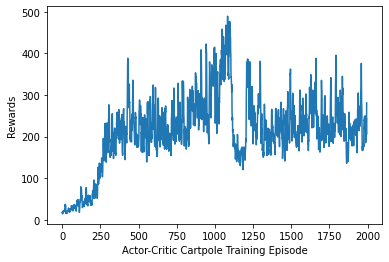

In [81]:
window = 5
plt.xlabel('Actor-Critic Cartpole Training Episode')
plt.ylabel('Rewards')
plt.plot([np.mean(rewards_cartpole[tr:tr+window]) for tr in range(window, len(rewards_cartpole))])

In [57]:
import gym
env = gym.make('CartPole-v1') 
env.reset()
done = False
#env.render()
#plt.show()
sum = 0
episode = 0
test_reward_cartpole = []

while episode <= 30:
    print('Episode ',episode)
    done = False
    obs = env.reset()
    sum = 0
    while not done:
        action = agent.step(obs)
        state = np.copy(obs)
        obs, reward, done, info = env.step(action)
        next_state = np.copy(obs)
        #env.render()
        #plt.show()
        #print('Action:', action)
        print('Reward:', reward)
        sum += reward
        print('Progressive Reward:', sum)
    print('************************************************************')
    episode = episode + 1;
    test_reward_cartpole.append(sum)

Episode  0
Reward: 1.0
Progressive Reward: 1.0
Reward: 1.0
Progressive Reward: 2.0
Reward: 1.0
Progressive Reward: 3.0
Reward: 1.0
Progressive Reward: 4.0
Reward: 1.0
Progressive Reward: 5.0
Reward: 1.0
Progressive Reward: 6.0
Reward: 1.0
Progressive Reward: 7.0
Reward: 1.0
Progressive Reward: 8.0
Reward: 1.0
Progressive Reward: 9.0
Reward: 1.0
Progressive Reward: 10.0
Reward: 1.0
Progressive Reward: 11.0
Reward: 1.0
Progressive Reward: 12.0
Reward: 1.0
Progressive Reward: 13.0
Reward: 1.0
Progressive Reward: 14.0
Reward: 1.0
Progressive Reward: 15.0
Reward: 1.0
Progressive Reward: 16.0
Reward: 1.0
Progressive Reward: 17.0
Reward: 1.0
Progressive Reward: 18.0
Reward: 1.0
Progressive Reward: 19.0
Reward: 1.0
Progressive Reward: 20.0
Reward: 1.0
Progressive Reward: 21.0
Reward: 1.0
Progressive Reward: 22.0
Reward: 1.0
Progressive Reward: 23.0
Reward: 1.0
Progressive Reward: 24.0
Reward: 1.0
Progressive Reward: 25.0
Reward: 1.0
Progressive Reward: 26.0
Reward: 1.0
Progressive Reward: 27.0

/var/folders/bw/ct_pt6j167xdyq81hd4jpdz40000gn/T/ipykernel_31543/1927055332.py:18: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  probabilities = F.softmax(self.actor.forward(observation))


Reward: 1.0
Progressive Reward: 3.0
Reward: 1.0
Progressive Reward: 4.0
Reward: 1.0
Progressive Reward: 5.0
Reward: 1.0
Progressive Reward: 6.0
Reward: 1.0
Progressive Reward: 7.0
Reward: 1.0
Progressive Reward: 8.0
Reward: 1.0
Progressive Reward: 9.0
Reward: 1.0
Progressive Reward: 10.0
Reward: 1.0
Progressive Reward: 11.0
Reward: 1.0
Progressive Reward: 12.0
Reward: 1.0
Progressive Reward: 13.0
Reward: 1.0
Progressive Reward: 14.0
Reward: 1.0
Progressive Reward: 15.0
Reward: 1.0
Progressive Reward: 16.0
Reward: 1.0
Progressive Reward: 17.0
Reward: 1.0
Progressive Reward: 18.0
Reward: 1.0
Progressive Reward: 19.0
Reward: 1.0
Progressive Reward: 20.0
Reward: 1.0
Progressive Reward: 21.0
Reward: 1.0
Progressive Reward: 22.0
Reward: 1.0
Progressive Reward: 23.0
Reward: 1.0
Progressive Reward: 24.0
Reward: 1.0
Progressive Reward: 25.0
Reward: 1.0
Progressive Reward: 26.0
Reward: 1.0
Progressive Reward: 27.0
Reward: 1.0
Progressive Reward: 28.0
Reward: 1.0
Progressive Reward: 29.0
Reward: 

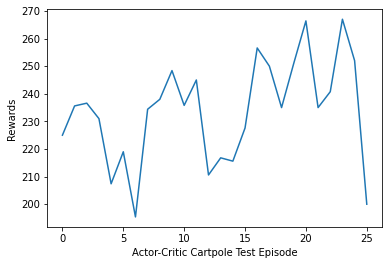

In [58]:
window = 5
plt.xlabel('Actor-Critic Cartpole Test Episode')
plt.ylabel('Rewards')
plt.plot([np.mean(test_reward_cartpole[tr:tr+window]) for tr in range(window, len(test_reward_cartpole))])

# Lunar Lander

In [7]:
import gym
from gym import spaces
import math
import random
from IPython.core.pylabtools import figsize
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline
from collections import namedtuple
from itertools import count
from PIL import Image

import torch as T
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import time

from collections import deque



In [8]:
env = gym.make('LunarLander-v2')
env.seed(0)
print('State shape: ', env.observation_space.shape)
print('Number of actions: ', env.action_space.n)

State shape:  (8,)
Number of actions:  4


2021-11-28 18:55:34.616 python[31543:8731925] Warning: Expected min height of view: (<NSPopoverTouchBarItemButton: 0x7fd6d4a8bbc0>) to be less than or equal to 30 but got a height of 32.000000. This error will be logged once per view in violation.
2021-11-28 18:55:34.616 python[31543:8731925] Warning: Expected min height of view: (<NSButton: 0x7fd6d546f670>) to be less than or equal to 30 but got a height of 32.000000. This error will be logged once per view in violation.
2021-11-28 18:55:34.618 python[31543:8731925] Warning: Expected min height of view: (<NSPopoverTouchBarItemButton: 0x7fd6d5471be0>) to be less than or equal to 30 but got a height of 32.000000. This error will be logged once per view in violation.
2021-11-28 18:55:34.619 python[31543:8731925] Warning: Expected min height of view: (<NSPopoverTouchBarItemButton: 0x7fd6d547b1b0>) to be less than or equal to 30 but got a height of 32.000000. This error will be logged once per view in violation.


Discrete(4)
Box([-inf -inf -inf -inf -inf -inf -inf -inf], [inf inf inf inf inf inf inf inf], (8,), float32)


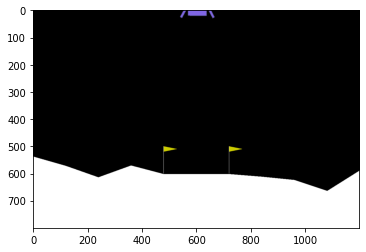

In [9]:
env = gym.make('LunarLander-v2')
env.reset()
plt.imshow(env.render('rgb_array'))
print(env.action_space)
print(env.observation_space)

/var/folders/bw/ct_pt6j167xdyq81hd4jpdz40000gn/T/ipykernel_31543/1927055332.py:18: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  probabilities = F.softmax(self.actor.forward(observation))


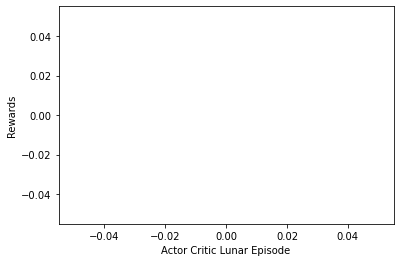

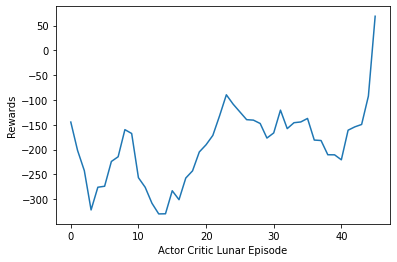

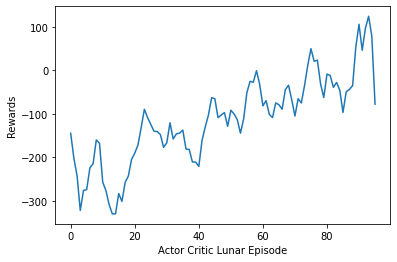

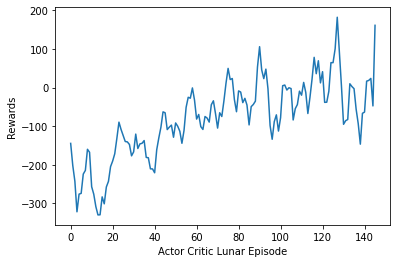

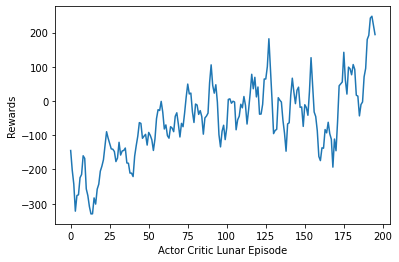

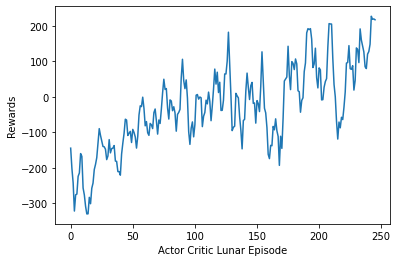

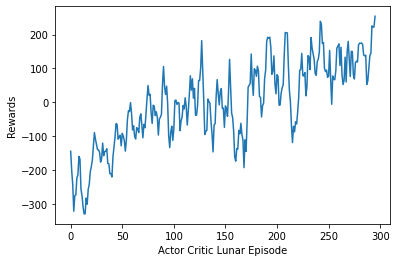

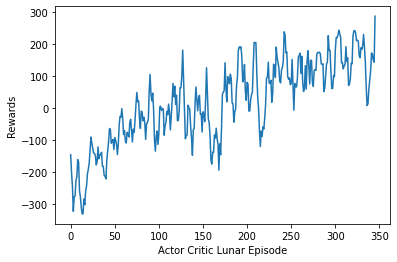

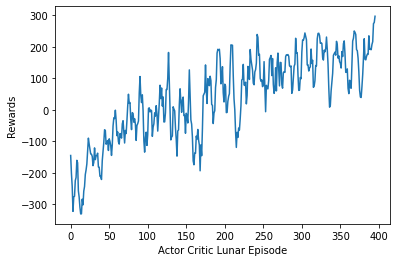

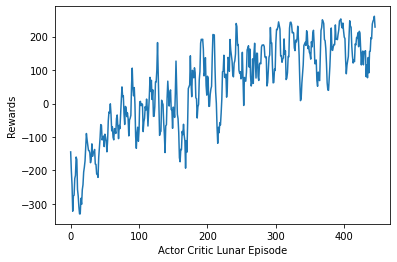

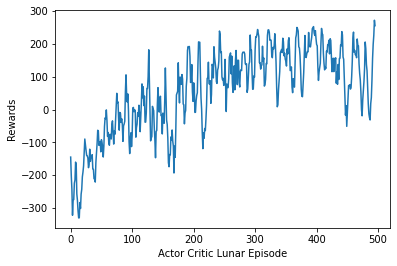

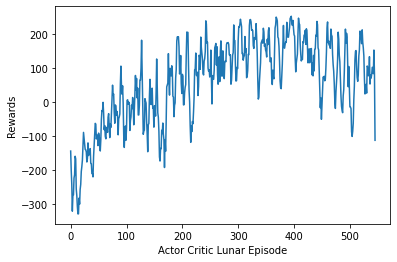

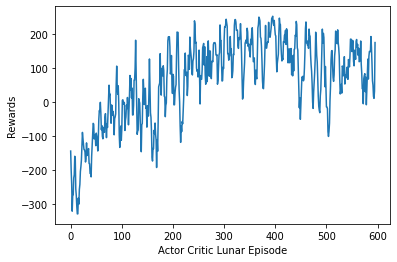

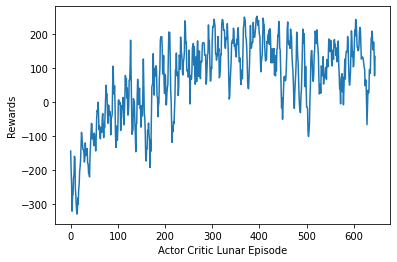

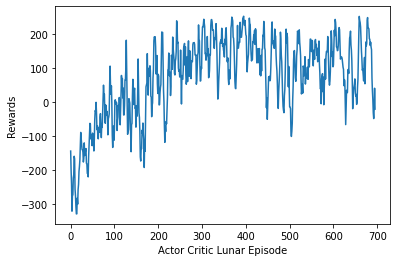

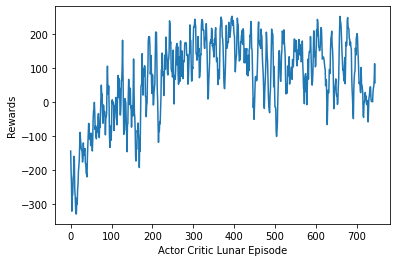

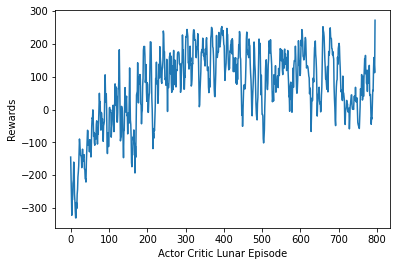

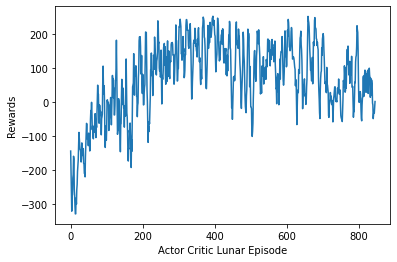

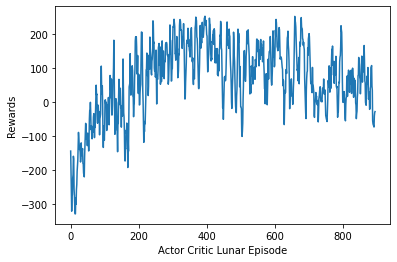

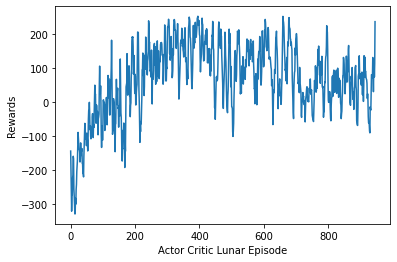

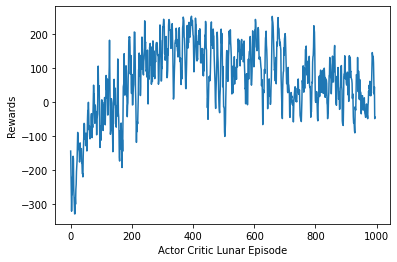

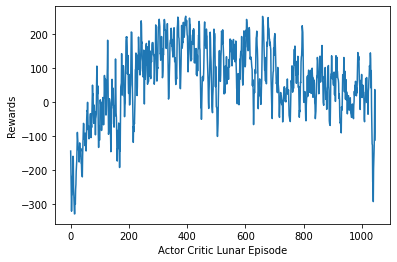

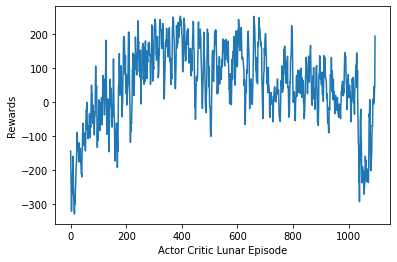

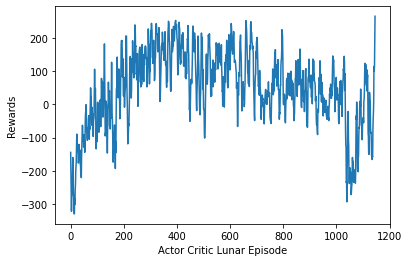

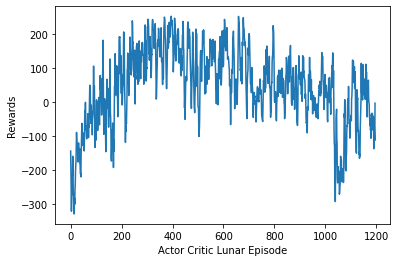

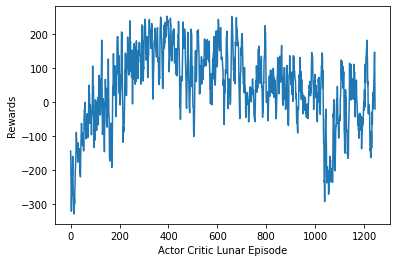

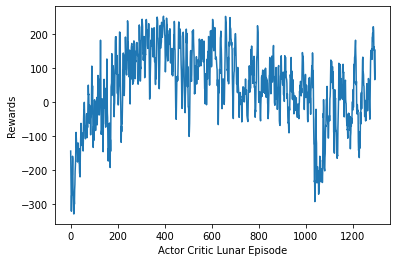

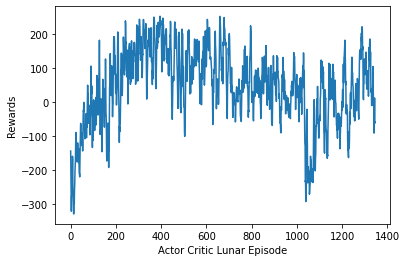

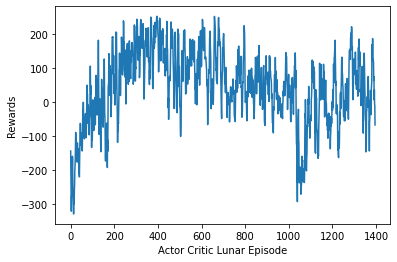

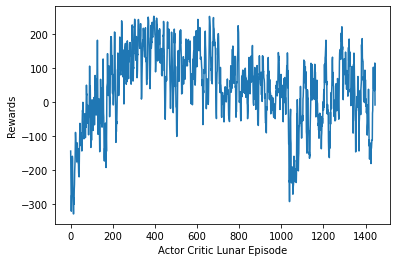

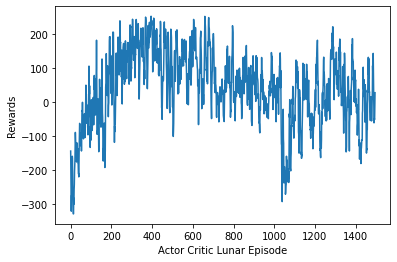

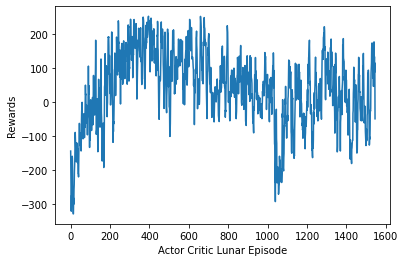

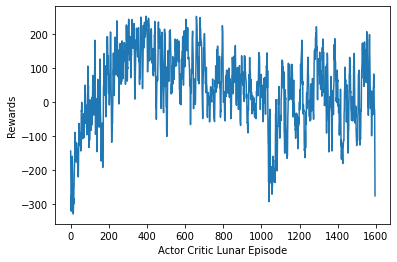

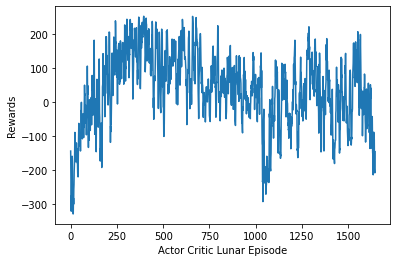

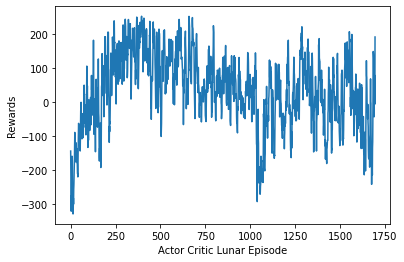

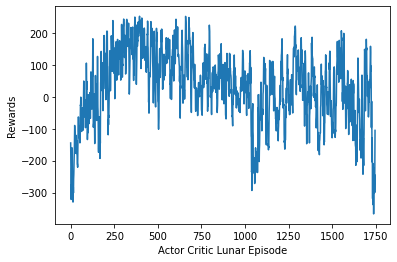

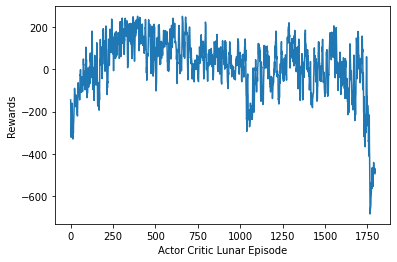

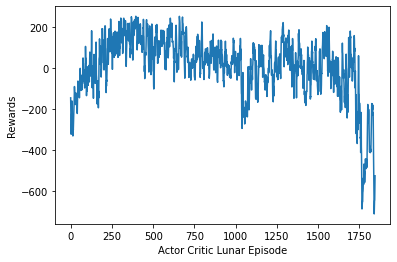

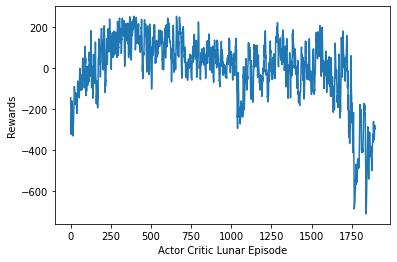

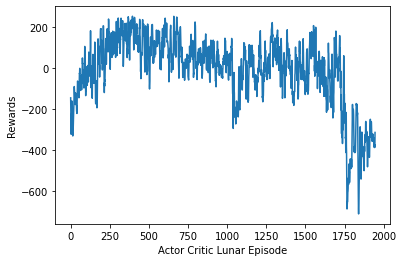

In [23]:
# setting up environment and agent
import gym
env = gym.make('LunarLander-v2') 
env.reset()


agent = ACAgent(env=env,alpha=0.0001, beta=0.0001, input_dims=8, gamma=0.99,fc1_dims=256, fc2_dims=512, n_actions=4)
episodes = 2000

rewards_lunar_lander = []

for episode in range(episodes):
    #print(episode)
    obs = env.reset()
    done = False
    curr_reward = 0

    while not done:
        action = agent.step(obs)
        state = np.copy(obs)
        obs, reward, done, info = env.step(action)
        curr_reward += reward
        next_state = np.copy(obs)

        agent.learn(state,reward,next_state,done)

  
    rewards_lunar_lander.append(curr_reward)

    if not episode%50:
        window = 5
        plt.xlabel('Actor Critic Lunar Episode')
        plt.ylabel('Rewards')
        plt.plot([np.mean(rewards_lunar_lander[tr:tr+window]) for tr in range(window, len(rewards_lunar_lander))])
        plt.show()



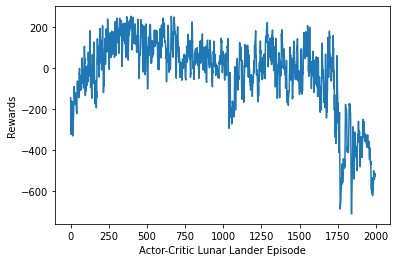

In [24]:
window = 5
plt.xlabel('Actor-Critic Lunar Lander Episode')
plt.ylabel('Rewards')
plt.plot([np.mean(rewards_lunar_lander[tr:tr+window]) for tr in range(window, len(rewards_lunar_lander))])

In [27]:
import gym
env = gym.make('LunarLander-v2') 
obs = env.reset()
done = False
env.render()
plt.show()
sum = 0
episode = 0
test_reward_lunar = []

while episode <= 30:
    print('Episode ',episode)
    done = False
    obs = env.reset()
    sum = 0
    while not done:
        action = agent.step(obs)
        obs, reward, done, info = env.step(action)
        env.render()
        #plt.show()
        #print('Action:', action)
        print('Reward:', reward)
        sum += reward
        print('Progressive Reward:', sum)
    print('************************************************************')
    episode = episode + 1;
    test_reward_lunar.append(sum)

2021-11-28 21:58:40.815 python[31543:8731925] Warning: Expected min height of view: (<NSPopoverTouchBarItemButton: 0x7fd7014ac630>) to be less than or equal to 30 but got a height of 32.000000. This error will be logged once per view in violation.
2021-11-28 21:58:40.815 python[31543:8731925] Warning: Expected min height of view: (<NSButton: 0x7fd7014de1c0>) to be less than or equal to 30 but got a height of 32.000000. This error will be logged once per view in violation.
2021-11-28 21:58:40.817 python[31543:8731925] Warning: Expected min height of view: (<NSPopoverTouchBarItemButton: 0x7fd7014dff00>) to be less than or equal to 30 but got a height of 32.000000. This error will be logged once per view in violation.
2021-11-28 21:58:40.818 python[31543:8731925] Warning: Expected min height of view: (<NSPopoverTouchBarItemButton: 0x7fd7014e5b90>) to be less than or equal to 30 but got a height of 32.000000. This error will be logged once per view in violation.
/var/folders/bw/ct_pt6j167x

Episode  0
Reward: 1.2747505482859196
Progressive Reward: 1.2747505482859196
Reward: 3.511520711594966
Progressive Reward: 4.786271259880886
Reward: 4.388387054580176
Progressive Reward: 9.174658314461063
Reward: 2.298749050645097
Progressive Reward: 11.473407365106159
Reward: 1.8732585216495579
Progressive Reward: 13.346665886755716
Reward: 3.001833094517406
Progressive Reward: 16.34849898127312
Reward: 1.9552635609366404
Progressive Reward: 18.30376254220976
Reward: 0.05353977003248361
Progressive Reward: 18.357302312242243
Reward: 1.9535546899557061
Progressive Reward: 20.31085700219795
Reward: 1.38287270068069
Progressive Reward: 21.693729702878638
Reward: 1.9497016725991727
Progressive Reward: 23.64343137547781
Reward: 0.5914253555878417
Progressive Reward: 24.23485673106565
Reward: -0.47013648663112234
Progressive Reward: 23.76472024443453
Reward: 0.4470215937511
Progressive Reward: 24.211741838185628
Reward: 0.8160279722113273
Progressive Reward: 25.027769810396954
Reward: -0.00

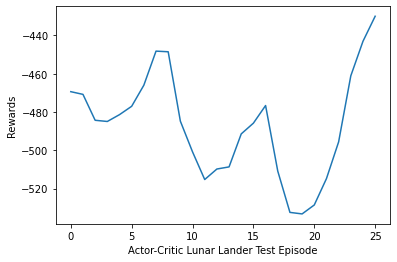

In [31]:
window = 5
plt.xlabel('Actor-Critic Lunar Lander Test Episode')
plt.ylabel('Rewards')
plt.plot([np.mean(test_reward_lunar[tr:tr+window]) for tr in range(window, len(test_reward_lunar))])

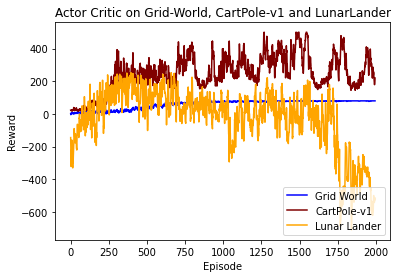

In [77]:
plt.title('Actor Critic on Grid-World, CartPole-v1 and LunarLander')
plt.xlabel('Episode')
plt.ylabel('Reward')

grid_world = [np.mean(q_d_rewards_1[tr:tr+window]) for tr in range(window, len(q_d_rewards_1))]
cartpole = [np.mean(rewards_cartpole[tr:tr+window]) for tr in range(window, len(rewards_cartpole))]
lunar_lander = [np.mean(rewards_lunar_lander[tr:tr+window]) for tr in range(window, len(rewards_lunar_lander))]
plt.plot(grid_world,'blue',label='Grid World')
plt.plot(cartpole, 'maroon',label = 'CartPole-v1')
plt.plot(lunar_lander, 'orange',label = 'Lunar Lander')
plt.legend(loc="lower right")
plt.show()